In [22]:
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import torch.nn as nn
import datetime, pytz
import time

In [24]:
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [26]:
# DATASET 
DATASET_CUTOFF = 1500 # 150000 maximo testeado hasta ahora

STEPS_IN = 100 # cantidad de filas del dataset con todos los features sin el Close que forman una secuencia
STEPS_OUT = 50 # cantidad de filas del dataset con el Close unicamente que estan luego de la secuencia in de arriba que forman una secuencia

TEST_SET_SIZE = 150
CUTOFF_PERCENTAGE = 0.90 # porcentaje de data usado para entrenar (el resto es para testear el modelo final)
# LSTM
N_EPOCHS = 1000 # 1000 epochs
LEARNING_RATE = 0.001 # 0.001 lr

HIDDEN_SIZE = 2 # number of features in hidden state
NUM_LAYERS = 1 # number of stacked lstm layers

NUM_CLASSES = STEPS_OUT # number of output classes: amount of minutes in the future to be predicted

HIDDEN_LAYER_FEATURES = 128

# Load dataset

In [27]:
df = pd.read_csv("processed_data_2/processed_bitcoin_history.csv", index_col = 'Timestamp', parse_dates=True)
df = df.drop(['Date','Target','Close_previous','Year','Month','Week','Weekday','Day','Hour'], axis=1)
df.head()

,Close,Volume_BTC,Volume_USD,volume_adi,volume_cmf,volume_fi,volume_vpt,volume_vwap,volatility_kcw,volatility_kchi,volatility_ui,trend_sma_slow,trend_kst_sig,trend_kst_diff,trend_ichimoku_b,trend_adx,momentum_stoch_signal,others_dr
Timestamp,,,,,,,,,,,,,,,,,,
2019-07-06 21:37:00+00:00,11241.11,0.506080,5688.393963,37.780369,0.422601,14.772576,0.000383,11215.859656,0.263751,1.0,0.153187,11202.031154,-73.474924,28.986836,11168.07,16.996894,83.220985,0.040938
2019-07-06 21:38:00+00:00,11248.61,2.446861,27503.127817,40.227230,0.326028,15.283845,0.001840,11217.293823,0.256345,1.0,0.145968,11205.404231,-66.264641,28.917487,11168.07,17.982966,90.308714,0.066719
2019-07-06 21:39:00+00:00,11246.58,0.422433,4751.750101,39.804797,0.476931,12.977933,0.001556,11217.596144,0.198862,1.0,0.137830,11208.785769,-59.055378,28.864806,11168.32,18.920838,94.992665,-0.018047
2019-07-06 21:40:00+00:00,11239.11,0.146191,1643.075035,39.658607,0.438422,10.967937,-0.000173,11217.722471,0.183756,0.0,0.085534,11211.991154,-51.859535,28.746847,11168.32,19.241752,93.807300,-0.066420
2019-07-06 21:41:00+00:00,11223.87,0.047598,534.559330,39.611009,0.490912,9.297461,-0.000162,11221.972207,0.179193,0.0,0.083956,11215.331154,-44.676338,28.621264,11168.32,18.532349,77.568653,-0.135598


In [28]:
df = df[-DATASET_CUTOFF:]

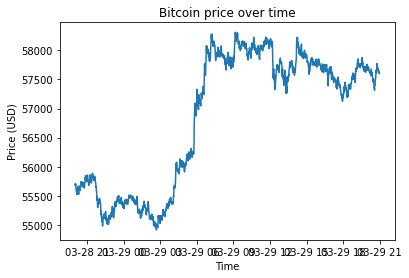

In [29]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [30]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1500, 17), (1500,))

In [31]:
NUMBER_OF_FEATURES = X.shape[1]

# Normalization of data

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
X_trans.shape, y_trans.shape

((1500, 17), (1500, 1))

In [33]:
# TODO: Revisar lo que hicimos en lstm con los index para ver si podemos reemplazar esto
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, STEPS_IN, STEPS_OUT)
print(X_ss.shape, y_mm.shape)

(1352, 100, 17) (1352, 50)


In [34]:

total_samples = len(X)
train_test_cutoff = round(CUTOFF_PERCENTAGE * total_samples)
X_train = X_ss[:-TEST_SET_SIZE]
X_test = X_ss[-TEST_SET_SIZE:]
y_train = y_mm[:-TEST_SET_SIZE]
y_test = y_mm[-TEST_SET_SIZE:] 
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (1202, 100, 17) (1202, 50)
Testing Shape: (150, 100, 17) (150, 50)


In [35]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

In [36]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0],
                                       X_train_tensors.shape[1], 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 
                                      X_train_tensors.shape[1],
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([1202, 100, 17]) torch.Size([1202, 50])
Testing Shape: torch.Size([150, 100, 17]) torch.Size([150, 50])


In [37]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2).to(device) # lstm
        self.fc_1 =  nn.Linear(hidden_size, HIDDEN_LAYER_FEATURES) # fully connected 
        self.fc_2 = nn.Linear(HIDDEN_LAYER_FEATURES, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [38]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    trainLossHistory = []
    testLossHistory = []
    
    print("Start of training.")
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f." % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
        # save loss results in history
        trainLossHistory.append(loss.item())
        testLossHistory.append(test_loss.item())
    
    print("End of training.")
    return trainLossHistory, testLossHistory

In [39]:
import warnings
warnings.filterwarnings('ignore')

INPUT_SIZE = NUMBER_OF_FEATURES # number of features

lstm = LSTM(
        NUM_CLASSES, 
        INPUT_SIZE, 
        HIDDEN_SIZE, 
        NUM_LAYERS
).to(device)

In [40]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

In [41]:
start = time.time()
trainLossHistory, testLossHistory = training_loop(n_epochs=N_EPOCHS,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)
end = time.time()

Start of training.
Epoch: 0, train loss: 0.47131, test loss: 0.56795.
Epoch: 100, train loss: 0.02009, test loss: 0.17317.
Epoch: 200, train loss: 0.00899, test loss: 0.00898.
Epoch: 300, train loss: 0.00704, test loss: 0.00314.
Epoch: 400, train loss: 0.00613, test loss: 0.00259.
Epoch: 500, train loss: 0.00564, test loss: 0.00268.
Epoch: 600, train loss: 0.00428, test loss: 0.00288.
Epoch: 700, train loss: 0.00367, test loss: 0.00312.
Epoch: 800, train loss: 0.00346, test loss: 0.00320.
Epoch: 900, train loss: 0.00328, test loss: 0.00367.
End of training.


In [43]:
print(f"Elapsed time: {round(end - start)}s")

Elapsed time: 8s


# Optimization loss evolution for train and test

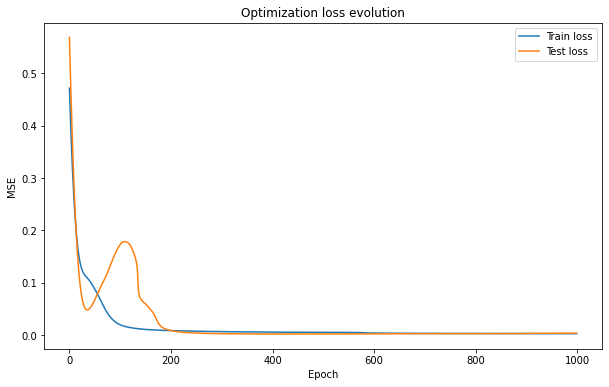

In [49]:
plt.figure(figsize=(10,6)) #plotting
plt.plot(trainLossHistory, label='Train loss')
plt.plot(testLossHistory, label='Test loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title('Optimization loss evolution')
plt.legend()
plt.savefig("optimization-loss-evolution.png", dpi=300)
plt.show() 

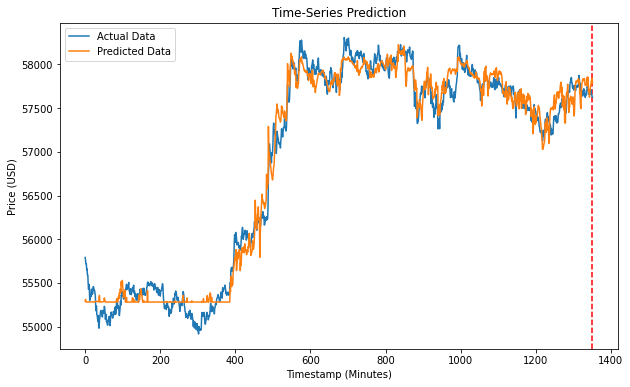

In [50]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, STEPS_IN, STEPS_OUT)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss).to(device))
df_y_mm = Variable(torch.Tensor(df_y_mm).to(device))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], df_X_ss.shape[1], df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.cpu().data.numpy() # numpy conversion
dataY_plot = df_y_mm.cpu().data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.xlabel("Timestamp (Minutes)")
plt.ylabel("Price (USD)")
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

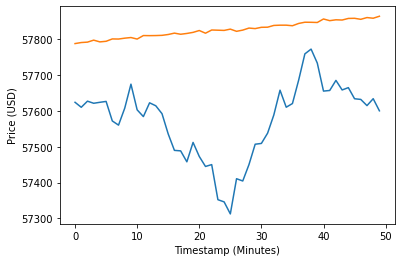

In [51]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.cpu().detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].cpu().detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.xlabel("Timestamp (Minutes)")
plt.ylabel("Price (USD)")
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

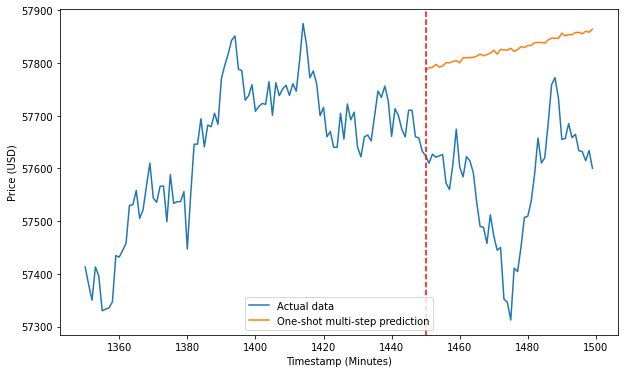

In [52]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(train_test_cutoff, len(y))]
plt.plot(a, y[train_test_cutoff:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.xlabel("Timestamp (Minutes)")
plt.ylabel("Price (USD)")
plt.plot(c, test_predict, label='One-shot multi-step prediction')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

# TODO: 
- agregar un numero que represente la precision del modelo (MSE por ejemplo) para comparar los distintos modelos y con distintos parametros
- scheduler
- Pruebas
    - El modelo con todos los features vs el modelo con los features iniciales
    - Agregar una capa extra para ver como se comporta vs la de 1 capa
    - Incrementar cantidad de neuronas para ver como se comporta vs la cant de neuronas iniciales
    - Cambiar steps in, step out
- Presentacion
    - Hablar de la diferencia entre predecir con una brecha de mins mas grande o mas chica a futuro
    - Hablar de LSTM de las capas y el rol que juegan
    - XGBoost contar el analisis de tendencia que hicimos con este
    - Agregar feature engineering
        - Agregar matriz de correlacion original y con todos los features
        - Discutir los features elegidos, contar algunos interesantes (no todos porque so 